In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#CONSTANTS
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "tomato_dataset",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
len(dataset)

501

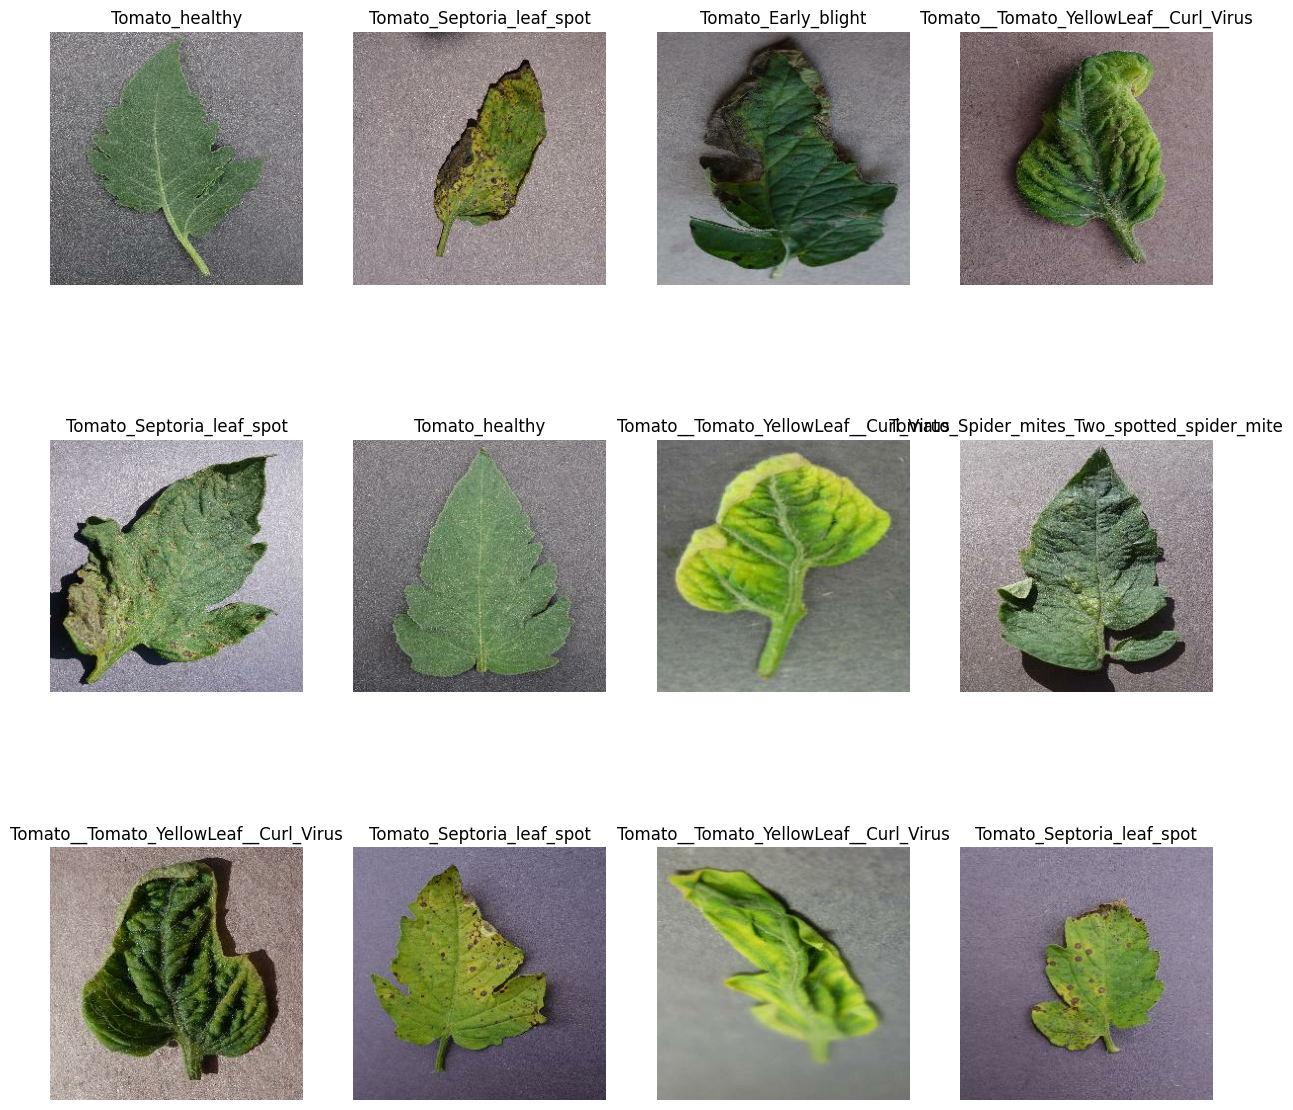

In [6]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(dataset,train_split=0.8,validation_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    dataset_size=len(dataset)
    if shuffle:
        dataset = dataset.shuffle(shuffle_size,seed=12)
    train_size = int(train_split*dataset_size)
    validation_size = int(validation_split*dataset_size)
    train_dataset = dataset.take(train_size)
    validation_dataset = dataset.skip(train_size).take(validation_size)
    test_dataset = dataset.skip(train_size).skip(validation_size)
    return train_dataset,validation_dataset,test_dataset

In [8]:
train_dataset, validation_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [9]:
len(train_dataset)

400

In [10]:
len(validation_dataset)

50

In [13]:
len(test_dataset)

51

In [11]:
train_dataset=train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset=validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset=test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
#Preprocessing i.e rescaling and resizing
resize_and_rescale = tf.keras.Sequential ([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
#Data Augmentation i.e rotational and flipping the images to capture every qngle of the leaf
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [19]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 10
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    #convolutional layer
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    #pooling layer
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
    
])
model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [21]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    train_dataset,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data = validation_dataset
)

Epoch 1/10
400/400 [==============================] - 2095s 5s/step - loss: 1.6415 - accuracy: 0.4238 - val_loss: 1.5188 - val_accuracy: 0.4906
Epoch 2/10
400/400 [==============================] - 1387s 3s/step - loss: 0.9893 - accuracy: 0.6509 - val_loss: 1.0758 - val_accuracy: 0.6475
Epoch 3/10
400/400 [==============================] - 1214s 3s/step - loss: 0.7565 - accuracy: 0.7324 - val_loss: 0.8556 - val_accuracy: 0.7056
Epoch 4/10
400/400 [==============================] - 1274s 3s/step - loss: 0.5849 - accuracy: 0.7993 - val_loss: 0.7388 - val_accuracy: 0.7287
Epoch 5/10
400/400 [==============================] - 1225s 3s/step - loss: 0.4716 - accuracy: 0.8354 - val_loss: 0.6352 - val_accuracy: 0.7906
Epoch 6/10
400/400 [==============================] - 1727s 4s/step - loss: 0.4144 - accuracy: 0.8534 - val_loss: 0.6327 - val_accuracy: 0.7850
Epoch 7/10
400/400 [==============================] - 1855s 5s/step - loss: 0.3595 - accuracy: 0.8705 - val_loss: 0.4427 - val_accuracy:

In [24]:
scores = model.evaluate(test_dataset)

51/51 [==============================] - 434s 916ms/step - loss: 0.4498 - accuracy: 0.8413


In [25]:
scores

[0.44983580708503723, 0.8412989974021912]

In [26]:
history

In [27]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 400}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss'] 

Text(0.5, 1.0, 'Training and validation Loss')

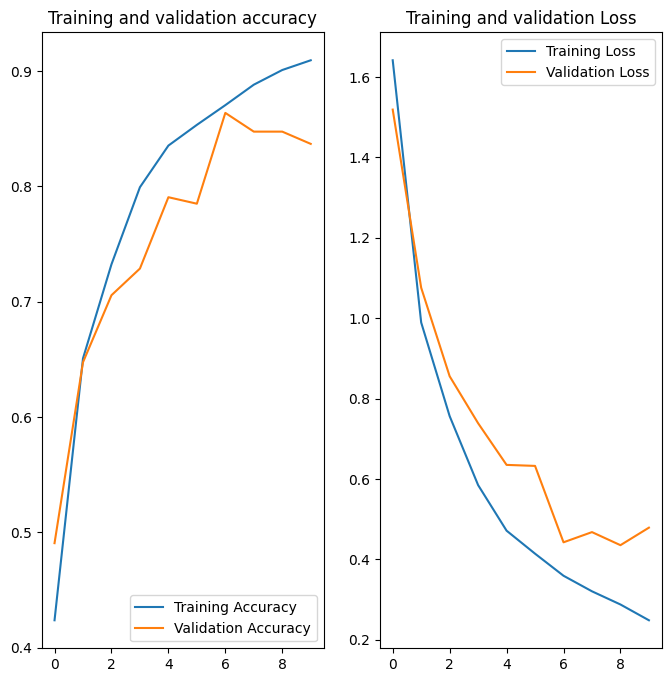

In [32]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),accuracy,label='Training Accuracy')
plt.plot(range(EPOCHS),validation_accuracy,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),validation_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and validation Loss')

first image to predict
actual label: Tomato__Tomato_YellowLeaf__Curl_Virus
1/1 [==============================] - 10s 10s/step
Predicted Label: Tomato__Tomato_YellowLeaf__Curl_Virus


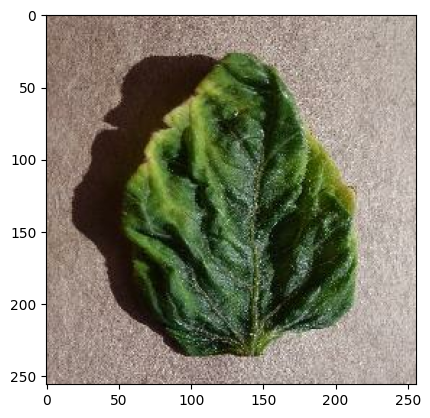

In [33]:
for images_batch, labels_batch in test_dataset.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    print('actual label:',class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [34]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


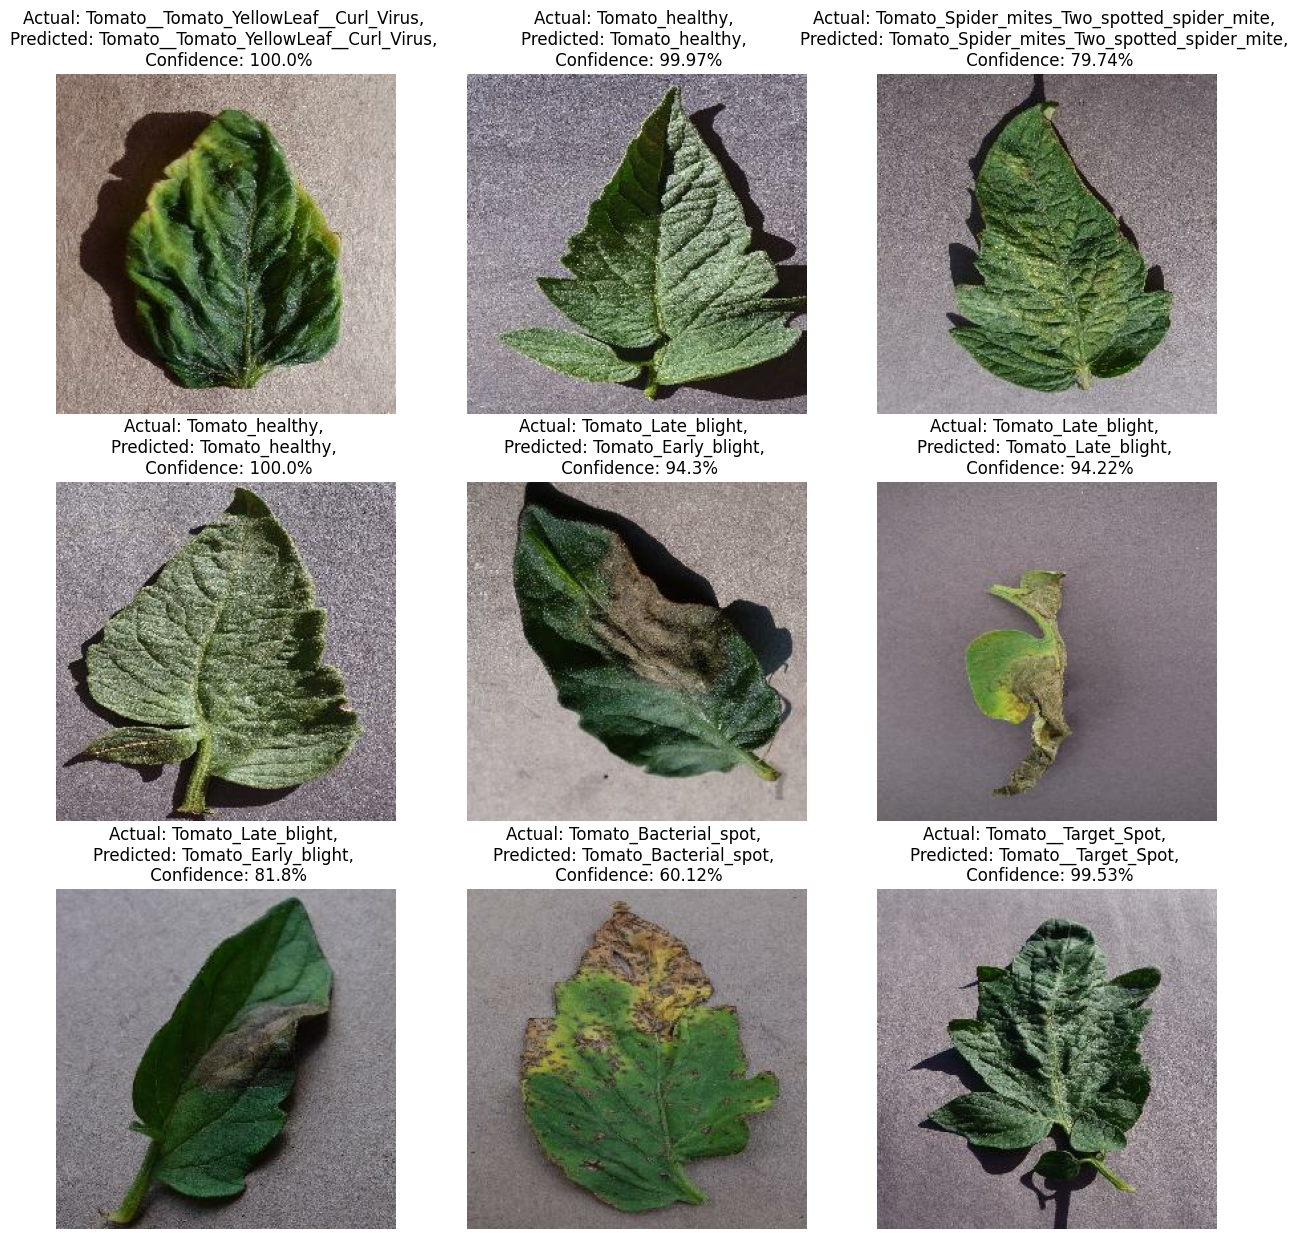

In [35]:
plt.figure(figsize=(15,15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \n Confidence: {confidence}%")
        plt.axis("off")

In [36]:
model_version = "tomato_model"
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/tomato_model\assets


INFO:tensorflow:Assets written to: ../models/tomato_model\assets
